In [3]:
#Selection of version of tensorflow in colab
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
# library import
import keras
import tensorflow as tf
from tensorflow.compat.v1  import  roll
import numpy as np
import cv2
from keras import optimizers
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, Add, Lambda
from keras.layers import Subtract, Layer, Cropping2D, Reshape
from keras.optimizers import *
from math import pi as pi
from scipy import signal
from keras import backend as K
from math import pi as pi
import matplotlib.pyplot as plt
import math
import os

In [4]:
from scipy.ndimage import label, generate_binary_structure
from scipy.io import loadmat

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

import LightPipes


print(tf.__version__)
print(keras.__version__)

from keras.constraints import Constraint
from mpl_toolkits.axes_grid1 import make_axes_locatable

from natsort import natsorted
import glob
import imageio
from skimage.io         import imread, imsave
from skimage.measure    import regionprops
from skimage.io         import imsave

2.5.0
2.5.0


In [13]:
import os
NOTEBOOK_DIR = os.getcwd()
ROOT = os.path.dirname(NOTEBOOK_DIR)

In [5]:
# Functions

def spiral_kxky(filename, ledNum):
    kxky = [[], []]
    with open(filename, 'r') as file:
        for line in file:
            for j, value in enumerate(line.split(",")):
                kxky[j].append(np.float(value))
    kxky = np.asarray(kxky)
    kxky = kxky.T
    return kxky[:ledNum, :]


def show_result(model, show=0, noShow=10,size=10):
    w_conv_Or = model.get_layer('O_FTr').get_weights()
    w_conv_Oi = model.get_layer('O_FTi').get_weights()
    w_conv_Or_array = np.asarray(w_conv_Or)
    w_conv_Oi_array = np.asarray(w_conv_Oi)
    c_real = w_conv_Or_array[0, :, :, 0].reshape((imSize, imSize))
    c_imag = w_conv_Oi_array[0, :, :, 0].reshape((imSize, imSize))
    
    c_complex = c_real + 1j * c_imag
    c_abs = np.abs(c_complex)
    c_phase = np.angle(c_complex+pi)
    im_spatial = np.abs(np.fft.ifft2(np.fft.ifftshift(c_complex)))
    im_phase = np.angle(np.fft.ifft2(np.fft.ifftshift(c_complex)))
    
    if show:
        plt.figure(figsize=(size,size))
        plt.subplot(233),plt.imshow(np.log(c_abs[noShow:imSize-noShow, noShow:imSize-noShow]+1), cmap='gray'),plt.title('recover (abs)')
        ax = plt.subplot(232)
        plot = plt.imshow(im_phase[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray')
        divider = make_axes_locatable(ax)
        plt.title('recover (phase)')
        cax = divider.append_axes("right", size="5%", pad=0.02)
        plt.colorbar(plot,cax=cax)
        plt.subplot(231),plt.imshow(im_spatial[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray'),plt.title('recover FT')
        plt.show()
        plt.show()
        
    return c_complex


class MyLayer(Layer):
    def __init__(self, output_dims, **kwargs):
        self.output_dims = output_dims

        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=self.output_dims,
                                      initializer='ones',
                                      trainable=True)

        super(MyLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        a = tf.keras.backend.reshape(x, shape=(-1,imSize,imSize,1))
        return tf.multiply(a,self.kernel)

    def compute_output_shape(self, input_shape):
        return (self.output_dims)


class take_one( Layer):
    def __init__(self, output_dims, **kwargs):
        self.output_dims = output_dims

        super(take_one, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=self.output_dims,
                                      initializer='ones',
                                      trainable=False)

        super(take_one, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        b = tf.keras.backend.reshape(x, shape=(1,1))
        a = tf.keras.backend.cast(b, dtype='int32')
        return a[:,0]*1

    def compute_output_shape(self, input_shape):
        return (self.output_dims)


class Between(Constraint):
    def __init__(self, min_value, max_value):
        self.min_value =  min_value
        self.max_value = max_value

    def __call__(self, w):        
        return K.clip(w, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value}

class ConvexCombination(Layer):
    def __init__(self, **kwargs):
        super(ConvexCombination, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lambd2 = self.add_weight(name='lambda2',
                                     shape=(10,1),  # Adding one dimension for broadcasting
                                     initializer='ones',  # Try also 'ones' and 'uniform'
                                     trainable=True,constraint =Between(-1.,1.) )
        super(ConvexCombination, self).build(input_shape)

    def call(self, x):
        # x is a list of two tensors with shape=(batch_size, H, T)
        h1,h2,h3,h4,h5,h6,h7,h8,h9,h10 = x
        a= self.lambd2[0,0]
        b= self.lambd2[1,0]
        c= self.lambd2[2,0]
        d= self.lambd2[3,0]
        e= self.lambd2[4,0]
        f= self.lambd2[5,0]
        g= self.lambd2[6,0]
        h= self.lambd2[7,0]
        i= self.lambd2[8,0]
        j= self.lambd2[9,0]
        # k= self.lambd2[10,0]
        # l= self.lambd2[11,0]

        new_ctf = a*h1 + b*h2 +  c*h3 + d*h4 + e*h5 + f*h6 + g*h7 + h*h8+i*h9 +j*h10#+ k*h11 +l*h12
        return new_ctf

    def compute_output_shape(self, input_shape):
        return input_shape[0]



In [6]:
# Set parameters
index_downSample = 2 # downsample: index_downSample=4
wlength = 0.620*1e-6
NA = 0.75
k0 = 2 * pi / wlength
magnif = 20
spsize = (3.45*1e-6)/magnif
psize = spsize/index_downSample
crop = 84
imSize = int(crop*index_downSample)
imCenter = int(imSize / 2)
arraysize = 5.97
NAstep = 0.05
dz = 21

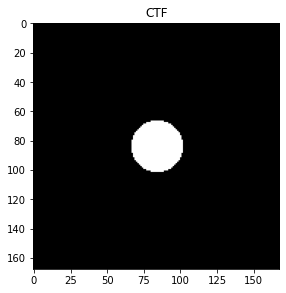

17.528225806451612


In [8]:
# Generate CTF
dkxy = 2*pi/(psize*imSize)
cutoffFrequency = (NA * k0 / dkxy)
center = [imCenter, imCenter]
kYY, kXX = np.ogrid[:imSize, :imSize]
CTF = np.sqrt((kXX - center[0]) ** 2 + (kYY - center[1]) ** 2) <= cutoffFrequency
CTF = CTF.astype(float)

# Show CTF
plt.figure(figsize=(15,15))
plt.xticks(np.arange(0,crop,20))
plt.subplot(1, 3, 3),plt.imshow(CTF[:,:], cmap='gray'),plt.title('CTF')
plt.show()

print(cutoffFrequency)

/Users/roberthajjar/Documents/projet_cassioppee/env/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


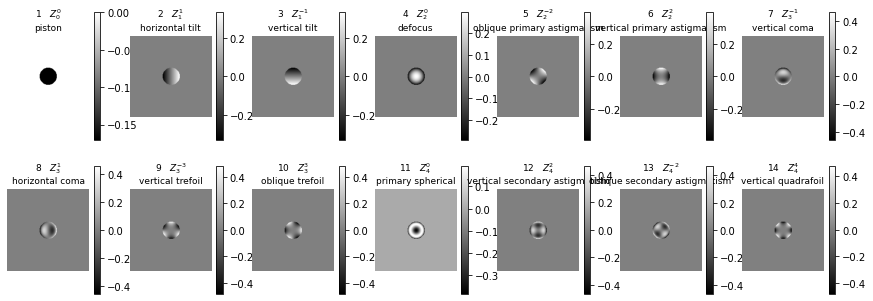

In [9]:
from LightPipes import *
import matplotlib.pyplot as plt
import math

wavelength=wlength
cutoffFrequency = (NA * k0 / dkxy)

size=cutoffFrequency
N=imSize
A=wavelength/(N/2*math.pi)

poly = np.ndarray([21,imSize,imSize],dtype=np.float128)

plt.figure(figsize=(15,8)) 
for Noll in range (1,15):
    (nz,mz)=noll_to_zern(Noll)
    S=ZernikeName(Noll)
    F=Begin(N,psize,N)
    F=Zernike(nz,mz,size,A,F)
    F=CircAperture(size,0,0,F)
    Phi=Phase(F)
    Z = Phi
    poly[Noll-1] = Z
    
    # ax1 = plt.subplot(3,7,Noll)
    # plot = plt.imshow(np.real(Z), cmap='gray')
    # plt.colorbar(plot,ax=ax1)
    # s=repr(Noll) + '  ' + ' $Z^{'+repr(mz)+'}_{'+repr(nz)+'}$' + '\n' + S
    # plt.title(s, fontsize=9);plt.axis('off')

    ax1 = plt.subplot(3,7,Noll)
    plot = plt.imshow(poly[Noll-1], cmap='gray')
    plt.colorbar(plot,ax=ax1)
    s=repr(Noll) + '  ' + ' $Z^{'+repr(mz)+'}_{'+repr(nz)+'}$' + '\n' + S
    plt.title(s, fontsize=9);plt.axis('off')
plt.show()


In [10]:
del Z,Phi,S,F

z1_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z2_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z3_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z4_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z5_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z6_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z7_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z8_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z9_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z10_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF

for i in range(int(arraysize ** 2)):
    z1_input[i, :, 0]  = np.reshape(poly[0],(imSize*imSize))
    z2_input[i, :, 0]  = np.reshape(poly[1],(imSize*imSize))
    z3_input[i, :, 0]  = np.reshape(poly[2],(imSize*imSize))
    z4_input[i, :, 0]  = np.reshape(poly[3],(imSize*imSize))
    z5_input[i, :, 0]  = np.reshape(poly[4],(imSize*imSize))
    z6_input[i, :, 0]  = np.reshape(poly[5],(imSize*imSize)) 
    z7_input[i, :, 0]  = np.reshape(poly[6],(imSize*imSize)) 
    z8_input[i, :, 0]  = np.reshape(poly[7],(imSize*imSize)) 
    z9_input[i, :, 0]  = np.reshape(poly[8],(imSize*imSize)) 
    z10_input[i, :, 0]  = np.reshape(poly[9],(imSize*imSize))
del poly

In [11]:
def create_model():
  center = imSize/2

  input_all = Input((imSize*imSize+2, 1),dtype='complex64', name='input_all')  # CTF
  input_measurement = Input((crop, crop, 1), name='input_measurement')  # measurement
  nule = Input((imSize,imSize, 1),dtype='float32', name='input_nule')  # CTF tf.ones(tf.shape(input_CTF), tf.float32)

  hx = int(center-crop/2)
  hy = int(center +crop/2)

  input_CTF = Lambda(lambda x: x[:,:imSize*imSize,:],name='input_CTF')(input_all)
  input_kx = Lambda(lambda x:  tf.real(x[:,imSize*imSize:imSize*imSize+1,:]),name='input_kx')(input_all)
  input_ky = Lambda(lambda x: tf.real(x[:,imSize*imSize+1:imSize*imSize+2,:]),name='input_ky')(input_all)

  z1 = Input((imSize*imSize, 1),dtype='float', name='z1')  # CTF
  z2 = Input((imSize*imSize, 1),dtype='float', name='z2')  # CTF
  z3 = Input((imSize*imSize, 1),dtype='float', name='z3')  # CTF
  z4 = Input((imSize*imSize, 1),dtype='float', name='z4')  # CTF
  z5 = Input((imSize*imSize, 1),dtype='float', name='z5')  # CTF
  z6 = Input((imSize*imSize, 1),dtype='float', name='z6')  # CTF
  z7 = Input((imSize*imSize, 1),dtype='float', name='z7')  # CTF
  z8 = Input((imSize*imSize, 1),dtype='float', name='z8')  # CTF
  z9 = Input((imSize*imSize, 1),dtype='float', name='z9')  # CTF
  z10 = Input((imSize*imSize, 1),dtype='float', name='z10')  # CTF
  z11 = Input((imSize*imSize, 1),dtype='float', name='z11')  # CTF
  z12 = Input((imSize*imSize, 1),dtype='float', name='z12')  # CTF


  kx_i = take_one((1,),input_shape = (1,1))(input_kx)
  ky_i = take_one((1,),input_shape = (1,1))(input_ky)

  # define O (FT)
  O_FTr = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='O_FTr')
  O_FTi = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='O_FTi')

  # define P
  P_r = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='P_r')
  P_i = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='P_i')

  # CTF * O (FT)
  CTFr = Lambda(lambda x: tf.real(x))(input_CTF)
  CTFi = Lambda(lambda x: tf.imag(x))(input_CTF)


  Comb = ConvexCombination(name='inter_z1')([z1,z2,z3,z4,z5,z6,z7,z8,z9,z10])

  Pupil = Lambda(lambda x: tf.exp(1j*tf.cast(x[0],tf.complex64))*x[1],name='Pupil')([Comb,input_CTF])


  Pupil_r = Lambda(lambda x: tf.real(x))(Pupil)
  Pupil_i = Lambda(lambda x: tf.imag(x))(Pupil)


  P_cr = P_r(Pupil_r)
  P_ci = P_i(Pupil_i)

  Or = O_FTr(nule)
  Oi = O_FTi(nule)


  Or_d =  Lambda(lambda x: roll(x[0],shift=[x[1][0],x[2][0]],axis=[1,2]),name='Roll_Or')([Or,kx_i,ky_i])  
  Oi_d =  Lambda(lambda x: roll(x[0],shift=[x[1][0],x[2][0]],axis=[1,2]),name='Roll_Oi')([Oi,kx_i,ky_i])


  CrOr_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_cr,Or_d])
  CiOi_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_ci,Oi_d])
  CrOi_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_cr,Oi_d])
  CiOr_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_ci,Or_d])

  CrOr = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CrOr')(CrOr_c)
  CiOi = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CiOi')(CiOi_c)
  CrOi = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CrOi')(CrOi_c)
  CiOr = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CiOr')(CiOr_c)

  # generate low resolution image (FT)
  lowFT_r = Subtract(name='lowFT_r')([CrOr, CiOi])
  lowFT_i = Add(name='lowFT_i')([CrOi, CiOr])

  lowFT = Lambda(lambda x: tf.cast(x[0], tf.complex64) + 1j * tf.cast(x[1], tf.complex64),name='lowFT')([lowFT_r, lowFT_i])
  # do ifft
  im_iFT = Lambda(lambda x: tf.ifft3d(tf.manip.roll(tf.cast(x, tf.complex64),[int(imSize/2), int(imSize/2)], axis=[0, 1])),name='low_iFT')(lowFT)

  image = Lambda(lambda x: tf.abs(x))(im_iFT)
  # keep angle, and use sqrt(I) to change the anplitude
  iFT_angle = Lambda(lambda x: tf.angle(tf.cast(x, tf.complex64)),name='low_iFT_angle')(im_iFT)

  sqrtI = Lambda(lambda x: tf.sqrt(x),name='input_amp')(input_measurement)

  output = Lambda(lambda x: tf.multiply(tf.cast(tf.divide(tf.reduce_sum(x[0]),tf.reduce_sum(x[1])), tf.float32),x[2]),output_shape=(crop,crop,1),name='out')([sqrtI, image,image])

  model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])
  #model.summary()

  return model

  #keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)



In [15]:
leds_path = os.path.join(ROOT,'data/positions_des_leds/pos_all_2.txt')
kakr = spiral_kxky(leds_path,int( arraysize ** 2)) # load kx, ky here
#print('kxky shape:',kakr.shape)

kx_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement
ky_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement


# Updating of positions according to errors found by the genetic algorithm
kakr[1,0] = kakr[1,0] +14.76734925
kakr[1,1] = kakr[1,1] +	0.59890099

kakr[2,0] = kakr[2,0] +14.89285647
kakr[2,1] = kakr[2,1] +0.92978567

kakr[3,0] = kakr[3,0] + 14.10572814 
kakr[3,1] = kakr[3,1] - 0.05350908

kakr[4,0] = kakr[4,0] + 14.70121004
kakr[4,1] = kakr[4,1] -0.96501889

kakr[5,0] = kakr[5,0] +14.02508033
kakr[5,1] = kakr[5,1] + 0.82702106

kakr[6,0] = kakr[6,0] + 14.97020396
kakr[6,1] = kakr[6,1] -  0.0542885

kakr[7,0] = kakr[7,0] -14.96710334  
kakr[7,1] = kakr[7,1] -0.77540696

kakr[9,0] = kakr[9,0] + 3.36549871
kakr[9,1] = kakr[9,1]  -0.40575659

kakr[11,0] = kakr[11,0] + 6.61696441 
kakr[11,1] = kakr[11,1] -0.65608742

kakr[12,0] = kakr[12,0] + 6.93462461 
kakr[12,1] = kakr[12,1] + 0.29434819

kakr[13,0] = kakr[13,0] + 5.15290666 
kakr[13,1] = kakr[13,1] + 0.62740655

kakr[14,0] = kakr[14,0] + 4.9515296
kakr[14,1] = kakr[14,1] + 0.46726247

kakr[15,0] = kakr[15,0] + 0.88872929 
kakr[15,1] = kakr[15,1] -0.00710684

kakr[16,0] = kakr[16,0] + 3.60385903 
kakr[16,1] = kakr[16,1] + 0.46693824

kakr[18,0] = kakr[18,0] -14.55634447  
kakr[18,1] = kakr[18,1] +  0.74065819

for i in range(35):
  kx_i[i,0,0] = (kakr[i,0]*(crop/500))*np.cos(kakr[i,1])
  ky_i[i,0,0] = (kakr[i,0]*(crop/500))*np.sin(kakr[i,1])
  #print(kakr[i])

<ipython-input-5-e6740b36bca2>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kxky[j].append(np.float(value))


In [16]:
#Function that uses the mask at the end of the FPM to save the cropped image
def extract_imagette(image, labeled,raw, coords_para, coords_distrac,cells_mean=60, size1=71, size2=71, 
                     travel_output=os.getcwd()+"_output/", tophat=False, zoro=False,mask=False):
  
    for region in regionprops(labeled):

        image_sortie=np.zeros([size1,size2], dtype='uint8')

        if region.equivalent_diameter>cells_mean*2/3:

            coords = region.coords
            
            #imagette image
            image_sortie[coords[:,0],coords[:,1]]=\
            image[coords[:,0],coords[:,1]]

            imsave(travel_output, image_sortie)


In [17]:
  # Generate CTFs
  imgs_train_input1 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.complex64) # input CTF
  imgs_train_input2 = np.ndarray((int(arraysize ** 2), crop, crop, 1)) # input CTF
  imgs_train_input4 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.float32) # input CTF
  kx_input = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement
  ky_input = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement


['9994A323901', '9994A323910', '9994A323919', '9994A323929', '9994A323938']
9994A323919
len(infected) 51


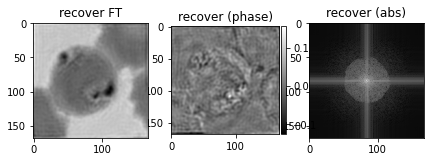

0 24.14465069770813


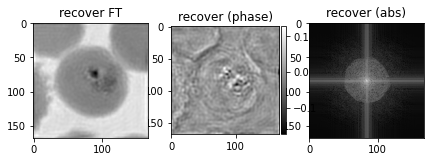

1 23.9707453250885


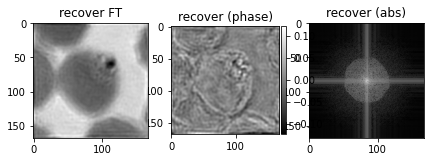

2 23.84853744506836


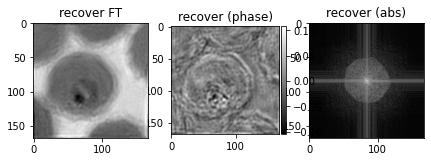

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_10386_1.png is a low contrast image


3 24.289824724197388


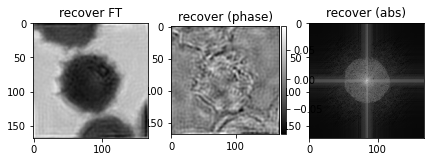

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_10405_1.png is a low contrast image


4 23.997730255126953


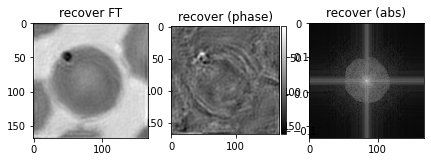

5 24.099770069122314


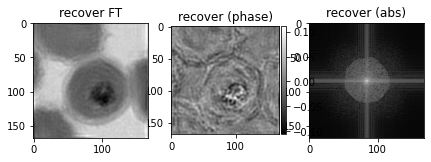

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_10455_1.png is a low contrast image


6 24.570548057556152


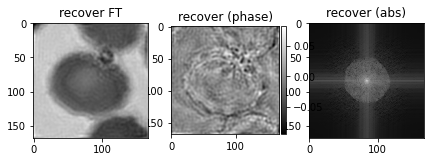

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_10633_1.png is a low contrast image


7 24.055783987045288


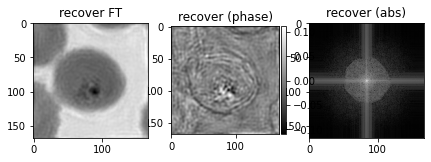

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_10648_1.png is a low contrast image


8 24.0298752784729


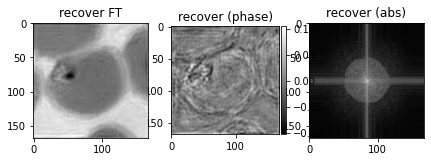

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_10682_1.png is a low contrast image


9 23.944268465042114


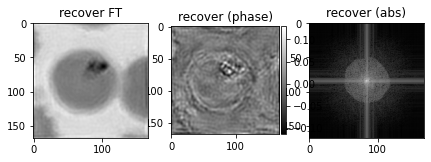

10 24.22322654724121


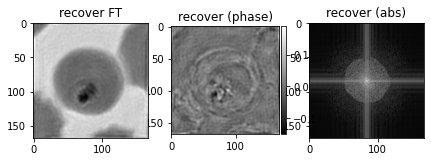

11 24.156110763549805


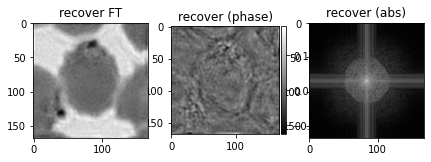

12 24.058757543563843


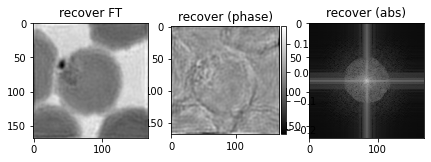

13 24.295226573944092


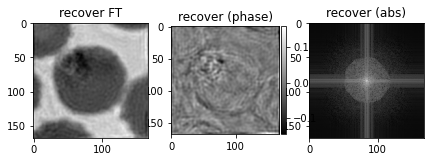

14 24.01355504989624


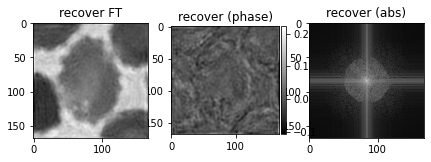

15 23.95116901397705


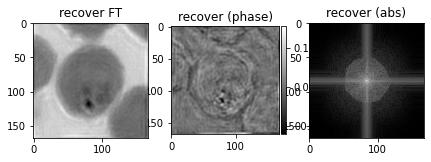

16 23.861384868621826


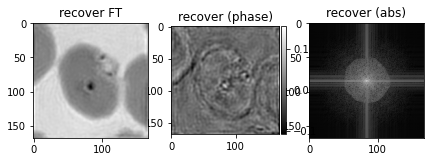

17 24.191779613494873


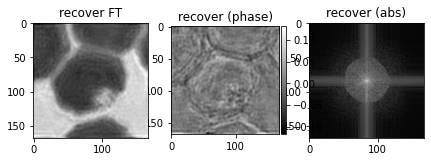

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_5477_1.png is a low contrast image


18 23.860215663909912


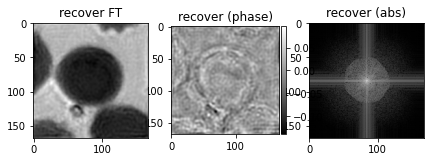

19 23.8304922580719


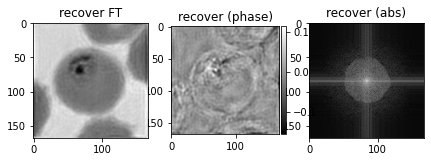

20 24.12652063369751


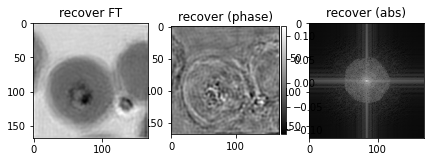

21 23.914143085479736


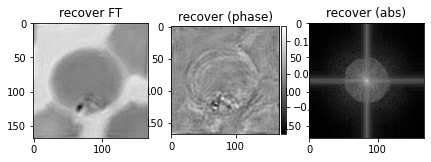

22 23.87107801437378


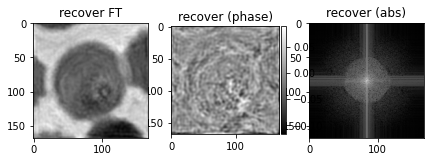

23 23.945762872695923


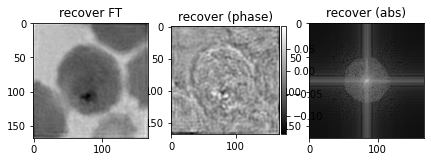

24 24.156141996383667


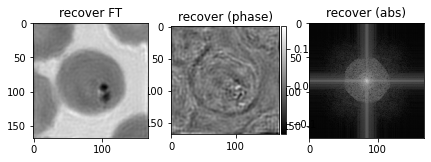

25 23.879698991775513


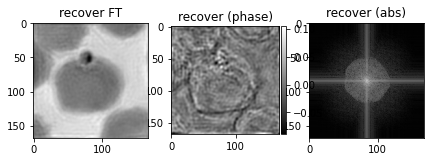

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_8361_1.png is a low contrast image


26 24.069146871566772


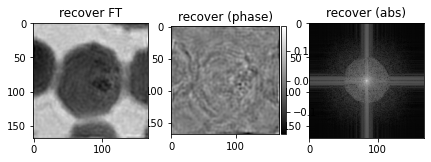

27 24.273310661315918


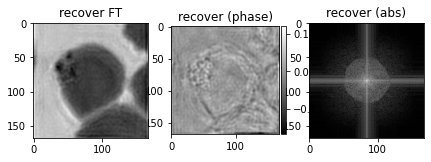

28 24.047226190567017


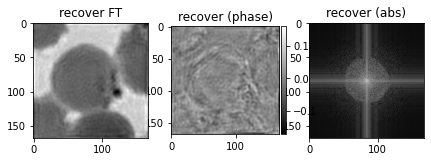

29 23.900567293167114


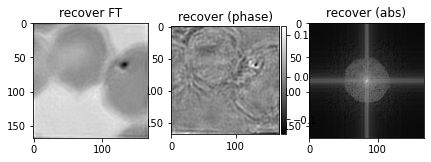

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_8516_1.png is a low contrast image


30 24.003568172454834


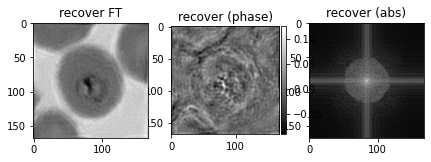

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_8518_1.png is a low contrast image


31 24.26319646835327


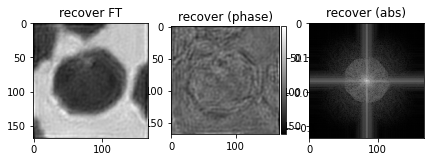

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_9319_1.png is a low contrast image


32 23.81260395050049


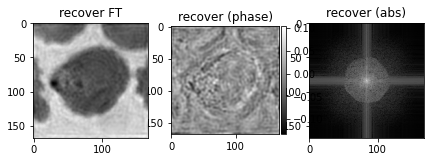

33 23.963366985321045


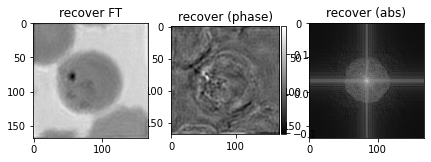

34 24.14115834236145


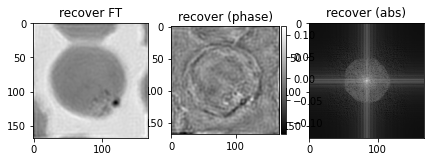

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_9443_1.png is a low contrast image


35 24.018824100494385


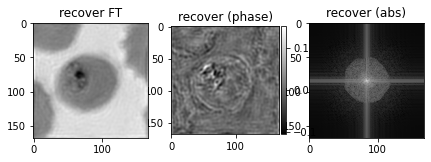

36 23.89977478981018


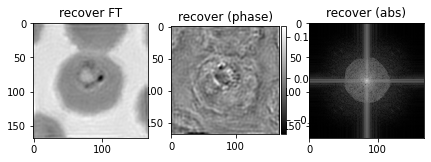

37 23.896474599838257


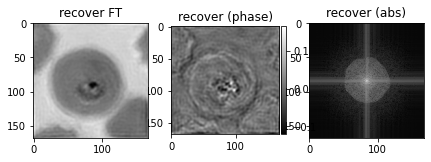

38 24.32985019683838


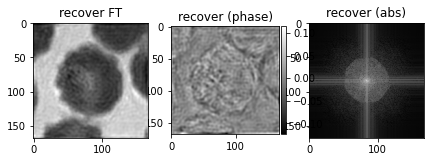

39 23.97624945640564


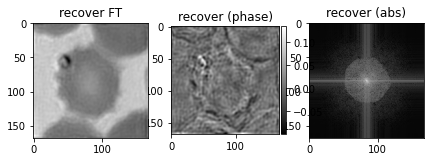

40 23.94885015487671


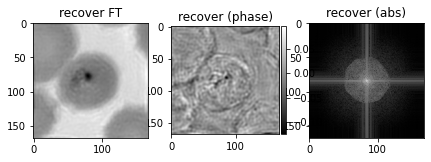

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_9595_1.png is a low contrast image


41 24.076563358306885


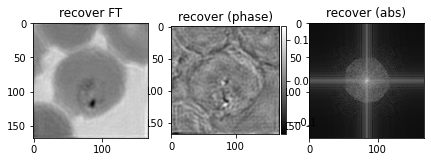

42 23.998836755752563


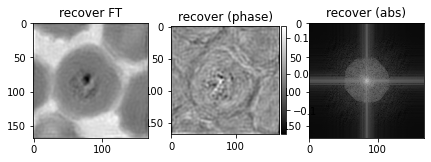

43 23.757181406021118


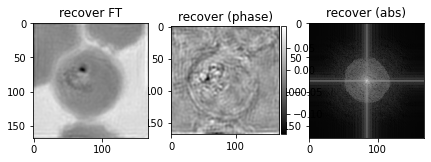

44 23.777953386306763


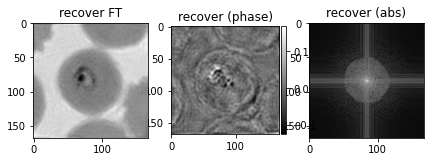

45 24.29434609413147


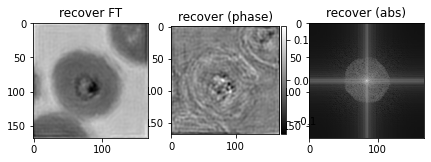

46 23.912883758544922


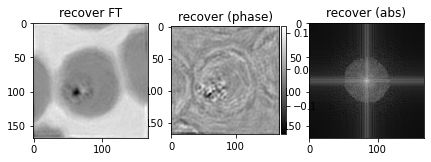

47 23.762110233306885


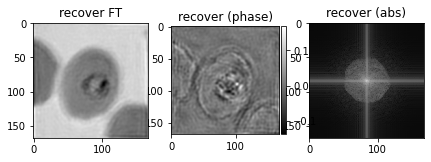

48 24.257110357284546


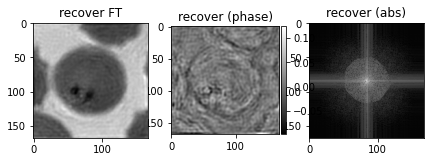

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: /content/drive/MyDrive/Design project/travel_out/infected/9994A323919/_infected_10063_1.png is a low contrast image


49 23.885878801345825


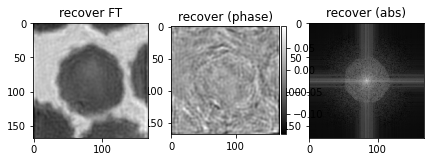

50 23.982621431350708


In [23]:
# Execution of neural network to do the reconstruction FPM and save the image
import time
original =np.ndarray((35, crop, crop))

# input data
login = "/content/drive/MyDrive/Stage_colab_shared/out/out"

print(os.listdir(login))

# choice witch directory you want work
list_log = os.listdir(login)[2:3] 

for log in list_log:
  print(log)
  travel = login+'/'+log+'/'

  infected = []
  healthy =[]
  # output data
  travel_output = "/content/drive/MyDrive/Design project/travel_out/infected/" + log+'/'

  if not os.path.exists(travel_output):
    os.makedirs(travel_output)

  for arch in os.listdir(travel):
    if 'infected' in arch:
      infected.append(arch)
    if 'healthy' in arch:
      healthy.append(arch)


  count = 0 
  Loss=np.zeros((len(infected),10))
  print('len(infected)',len(infected))
  for ch in infected:
      start = time.time()
      tf.keras.backend.clear_session()
      title1 ='_' + ch +'_0.png'
      title2 ='_' + ch +'_1.png'
      i = 0
      celule = travel + ch +'/'
      for image_path in natsorted(glob.glob(celule+'*.png')):
        image = imageio.imread(image_path)
        if 'mask' not in image_path:
          original[i] = cv2.fastNlMeansDenoising(image,None,3,7,15)  
          i = i+1
        else:
          mask = label(resize(image, (image.shape[0] *2, image.shape[1]*2),anti_aliasing=True))[0]
      divs = original.copy()
      
      cell = divs

      # Generate CTFs
      imgs_train_input1 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.complex64) # input CTF
      imgs_train_input2 = np.ndarray((int(arraysize ** 2), crop, crop, 1)) # input CTF
      imgs_train_input4 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.float32) # input CTF

      for i in range(int(arraysize ** 2)):
          imgs_train_input2[i, :, :, 0] = cell[i]
          imgs_train_input1[i, :, :, 0] = CTF.astype(np.complex64)
          imgs_train_input4[i, :, :, 0] = np.ones(( imSize, imSize),np.float32)

      imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

      imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

      model = create_model()

      weight_or = np.ndarray((1, imSize, imSize, 1))
      weight_oi = np.ndarray((1, imSize, imSize, 1))

      weight_pr = np.ndarray((1, imSize, imSize, 1))
      weight_pi = np.ndarray((1, imSize, imSize, 1))

      weight_z1 = np.zeros((10, 1))

      imgs_test_predict = np.sqrt(imgs_train_input2)

      # set low res image FT as the initial weight
      imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
      weight_or[0, :, :, 0] = np.real(imlowFT1)
      weight_oi[0, :, :, 0] = np.imag(imlowFT1)

      model.get_layer('O_FTr').set_weights(weight_or)
      model.get_layer('O_FTi').set_weights(weight_oi)
      model.get_layer('inter_z1').set_weights([weight_z1])

      model.get_layer('P_r').trainable = False
      model.get_layer('P_i').trainable = False
      model.get_layer('O_FTr').trainable = False
      model.get_layer('O_FTi').trainable = False
      model.get_layer('inter_z1').trainable = True

      adam = Adagrad(learning_rate=0.01)
      model.compile(loss='mean_absolute_error', optimizer=adam)
      history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=10, verbose=0, shuffle=False)



      model.get_layer('O_FTr').trainable = True
      model.get_layer('O_FTi').trainable = True
      model.get_layer('inter_z1').trainable = False

      w_conv_Or = model.get_layer('O_FTr').get_weights()
      w_conv_Oi = model.get_layer('O_FTi').get_weights()
      w_conv_Or_array = np.asarray(w_conv_Or)
      w_conv_Oi_array = np.asarray(w_conv_Oi)
      c_real = w_conv_Or_array[0, :, :, 0].reshape((imSize, imSize))
      c_imag = w_conv_Oi_array[0, :, :, 0].reshape((imSize, imSize))

      weight_or[0, :, :, 0] = c_real
      weight_oi[0, :, :, 0] = c_imag 

      model.get_layer('O_FTr').set_weights(weight_or)
      model.get_layer('O_FTi').set_weights(weight_oi)

      #start2 = time.time()
      adam = RMSprop(learning_rate=10)
      model.compile(loss="mean_absolute_error", optimizer=adam)
      history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=10, verbose=0, shuffle=False)
      Loss[count,:]=history.history['loss']

      w_conv_Or = model.get_layer('O_FTr').get_weights()
      w_conv_Oi = model.get_layer('O_FTi').get_weights()
      w_conv_Or_array = np.asarray(w_conv_Or)
      w_conv_Oi_array = np.asarray(w_conv_Oi)
      c_real = w_conv_Or_array[0, :, :, 0].reshape((imSize, imSize))
      c_imag = w_conv_Oi_array[0, :, :, 0].reshape((imSize, imSize))

      c_complex = c_real + 1j * c_imag
      c_abs = np.abs(c_complex)
      c_phase = np.angle(c_complex+pi)
      im_spatial = np.abs(np.fft.ifft2(np.fft.ifftshift(c_complex)))
      im_phase = np.angle(np.fft.ifft2(np.fft.ifftshift(c_complex)))

      #show output:
      plt.figure(figsize=(7,7))
      plt.subplot(233),plt.imshow(np.log(c_abs+1), cmap='gray'),plt.title('recover (abs)')
      ax = plt.subplot(232)
      plot = plt.imshow(im_phase, cmap='gray')
      divider = make_axes_locatable(ax)
      plt.title('recover (phase)')
      cax = divider.append_axes("right", size="5%", pad=0.02)
      plt.colorbar(plot,cax=cax)
      plt.subplot(231),plt.imshow(im_spatial, cmap='gray'),plt.title('recover FT')
      plt.show()
 

      classe=regionprops(mask)

      image = im_spatial
      #normalise image
      if image.dtype!='uint8':
          img_cr=(image -image.min())/(image.max()-image.min())
          image=img_cr*255
          del(img_cr)
          image=np.array(image, dtype='uint8')
      extract_imagette(image, mask, coords_para=False, coords_distrac=False,raw=i,cells_mean=60, size1=imSize, size2=imSize,  travel_output=travel_output+title2,mask=False)


      image = im_phase
      #normalise image
      if image.dtype!='uint8':
          img_cr=(image -image.min())/(image.max()-image.min())
          image=img_cr*255
          del(img_cr)
          image=np.array(image, dtype='uint8')
      extract_imagette(image, mask, coords_para=False, coords_distrac=False,raw=i,cells_mean=60, size1=imSize, size2=imSize,  travel_output=travel_output+title1,mask=False)
      end = time.time()
      print(count,end-start)
      count = count+1
      
      # to save the image in intensity and phase
      # os.makedirs(travel_output)
      imsave(travel_output+title1, im_spatial)
      imsave(travel_output+title2, im_phase)

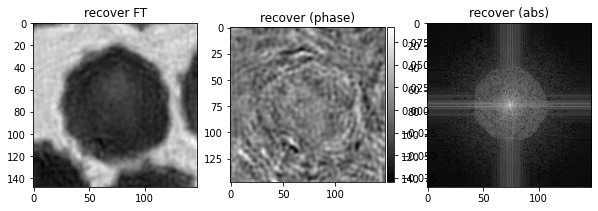

array([[-0.7808179 -1.7263968e-14j, -0.77929485-1.6448298e-02j,
        -0.7830701 -3.0874761e-02j, ..., -0.77659214+4.5798928e-02j,
        -0.7830701 +3.0874761e-02j, -0.77929485+1.6448298e-02j],
       [-0.7803706 -1.5357576e-02j, -0.7784265 -3.1791143e-02j,
        -0.7818999 -4.6152856e-02j, ..., -0.7770124 +3.0438535e-02j,
        -0.7831114 +1.5592931e-02j, -0.77910477+1.1308906e-03j],
       [-0.7797583 -3.2006647e-02j, -0.7775838 -4.8440907e-02j,
        -0.7806678 -6.3140094e-02j, ..., -0.7769544 +1.3749391e-02j,
        -0.78317195-1.3433811e-03j, -0.77886057-1.5590374e-02j],
       ...,
       [-0.7848269 +5.1229917e-02j, -0.7844881 +3.4548040e-02j,
        -0.7887327 +2.0160090e-02j, ..., -0.7778381 +9.6966907e-02j,
        -0.78516465+8.2131028e-02j, -0.78206205+6.7537814e-02j],
       [-0.7797583 +3.2006647e-02j, -0.77886057+1.5590374e-02j,
        -0.78317195+1.3433811e-03j, ..., -0.7738443 +7.7866383e-02j,
        -0.7806678 +6.3140094e-02j, -0.7775838 +4.8440907e-02j]

In [24]:
#Using the Genetic Algorithm
show_result(model, show=5, noShow=10,size=10)

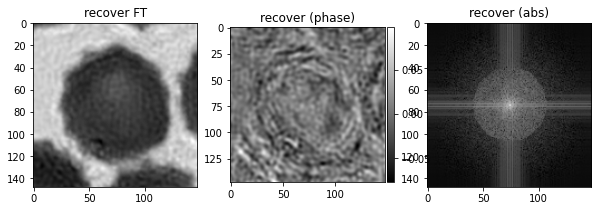

array([[-0.7808179 -1.7263968e-14j, -0.77929485-1.6448298e-02j,
        -0.7830701 -3.0874761e-02j, ..., -0.77659214+4.5798928e-02j,
        -0.7830701 +3.0874761e-02j, -0.77929485+1.6448298e-02j],
       [-0.7803706 -1.5357576e-02j, -0.7784265 -3.1791143e-02j,
        -0.7818999 -4.6152856e-02j, ..., -0.7770124 +3.0438535e-02j,
        -0.7831114 +1.5592931e-02j, -0.77910477+1.1308906e-03j],
       [-0.7797583 -3.2006647e-02j, -0.7775838 -4.8440907e-02j,
        -0.7806678 -6.3140094e-02j, ..., -0.7769544 +1.3749391e-02j,
        -0.78317195-1.3433811e-03j, -0.77886057-1.5590374e-02j],
       ...,
       [-0.7848269 +5.1229917e-02j, -0.7844881 +3.4548040e-02j,
        -0.7887327 +2.0160090e-02j, ..., -0.7778381 +9.6966907e-02j,
        -0.78516465+8.2131028e-02j, -0.78206205+6.7537814e-02j],
       [-0.7797583 +3.2006647e-02j, -0.77886057+1.5590374e-02j,
        -0.78317195+1.3433811e-03j, ..., -0.7738443 +7.7866383e-02j,
        -0.7806678 +6.3140094e-02j, -0.7775838 +4.8440907e-02j]

In [19]:
#without the Use of Genetic Algorithm
show_result(model, show=5, noShow=10,size=10)

In [18]:
#Loss for infected cells without position correction
Loss
with open('/content/drive/MyDrive/Design project/travel_out/data_inf_without/Loss_inf_without.npy','wb') as f:
  np.save(f,Loss)

array([[0.79575373, 0.78198437, 0.77172232, 0.76328449, 0.75621239,
        0.75023983, 0.745109  , 0.74066261, 0.73679429, 0.73342852],
       [0.8094254 , 0.79940376, 0.79206746, 0.78602834, 0.78094979,
        0.77664907, 0.77295299, 0.76971616, 0.76691392, 0.7644535 ],
       [0.87688495, 0.85915788, 0.84569748, 0.83433252, 0.8246248 ,
        0.81631006, 0.80908738, 0.80277573, 0.7971787 , 0.79222546],
       [0.79007022, 0.7729643 , 0.76005622, 0.74930546, 0.7402692 ,
        0.73264115, 0.72626412, 0.72089858, 0.71640458, 0.71261355],
       [0.68250845, 0.66832131, 0.65906888, 0.65233946, 0.64730924,
        0.64341884, 0.64034077, 0.63785511, 0.63581887, 0.63415108],
       [0.79603846, 0.78392973, 0.77530254, 0.76843895, 0.76288799,
        0.75832083, 0.75451793, 0.75130753, 0.74855509, 0.74619935],
       [0.75802943, 0.74122265, 0.72886177, 0.71874938, 0.71041247,
        0.70364105, 0.69821415, 0.69385546, 0.69031106, 0.68742365],
       [0.68856445, 0.67658629, 0.6681919

In [25]:
#Loss for infected cells without position correction
print(Loss)
with open('/content/drive/MyDrive/Design project/travel_out/data_inf_without/Loss_inf.npy','wb') as f:
  np.save(f,Loss)

[[0.78264108 0.76872561 0.75842612 0.74995964 0.74288749 0.73688244
  0.73177993 0.72741887 0.72365378 0.72034945]
 [0.80070696 0.79054058 0.78321643 0.77736621 0.77250105 0.7684641
  0.76507355 0.76215973 0.75962194 0.75739324]
 [0.8632326  0.84523916 0.83157878 0.8201497  0.81043261 0.8021358
  0.79492074 0.78861667 0.78307542 0.77819556]
 [0.78326184 0.76561357 0.75229093 0.74119425 0.73185705 0.72402757
  0.71751736 0.71206005 0.70747454 0.70356392]
 [0.66764464 0.65343461 0.64407098 0.63738124 0.63239998 0.62863137
  0.62570086 0.62338186 0.6215129  0.61999684]
 [0.79090156 0.77872245 0.76998628 0.7631263  0.75754002 0.75291106
  0.74906105 0.74580652 0.74305477 0.74068018]
 [0.75126933 0.73430098 0.72179548 0.7116457  0.70331741 0.69652116
  0.69100203 0.68655403 0.68291929 0.67995945]
 [0.66989042 0.65798589 0.64968236 0.64321944 0.63802231 0.63379751
  0.63030238 0.62740584 0.62498155 0.62294612]
 [0.85558559 0.84356447 0.83442963 0.82668201 0.81997509 0.81403546
  0.80875746 0

In [ ]:
#with genetic Algo

[0.87452797 0.86479923 0.8577454  0.85193694 0.84703803 0.84289071
  0.83938028 0.83637673 0.83376946 0.83151821]

#without genetic Algo

[0.88420992, 0.87406858, 0.86664488, 0.86054777, 0.85537407,
    0.85096481, 0.84722848, 0.84403534, 0.84127988, 0.8388821]


In [ ]:
import os 
os.path.getsize('/content/drive/MyDrive/Stage_colab_shared/out/out/9994A323919')

4096